In [1]:
"""
Notebook: 02_cohort_definition.ipynb
Define study cohort with inclusion/exclusion criteria and create readmission labels
"""

# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

# Load config
with open('../configs/config.json', 'r') as f:
    config = json.load(f)

data_dir = Path('../data/raw')
print("✓ Setup complete")


✓ Setup complete


In [2]:
# Cell 2: Load Core Tables
"""
Load the essential tables for cohort definition
"""
print("Loading data tables...")

admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')
patients = pd.read_csv(data_dir / 'PATIENTS.csv')
notes = pd.read_csv(data_dir / 'NOTEEVENTS_with_discharge_text.csv')

# Standardize column names to uppercase
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()
notes.columns = notes.columns.str.upper()

# Convert date columns
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])
admissions['EDREGTIME'] = pd.to_datetime(admissions['EDREGTIME'])
admissions['EDOUTTIME'] = pd.to_datetime(admissions['EDOUTTIME'])

patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])

print(f"✓ Loaded {len(admissions)} admissions")
print(f"✓ Loaded {len(patients)} patients")
print(f"✓ Loaded {len(notes)} clinical notes")


Loading data tables...
✓ Loaded 129 admissions
✓ Loaded 100 patients
✓ Loaded 129 clinical notes


In [3]:
# Cell 3: Calculate Basic Features
"""
Add essential calculated fields
"""
print("Calculating admission features...")

# Ensure all columns are uppercase
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()

# Merge patient info (DOB, DOD, GENDER)
admissions = admissions.merge(
    patients[['SUBJECT_ID', 'DOB', 'DOD', 'GENDER']], 
    on='SUBJECT_ID',
    how='left'
)

# Convert datetime columns safely
for col in ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOB']:
    admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

# Calculate length of stay in days
admissions['LOS_DAYS'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds() / 86400

# Calculate age at admission safely
admissions['AGE'] = admissions['ADMITTIME'].dt.year - admissions['DOB'].dt.year
admissions['AGE'] -= ((admissions['ADMITTIME'].dt.month < admissions['DOB'].dt.month) |
                      ((admissions['ADMITTIME'].dt.month == admissions['DOB'].dt.month) &
                       (admissions['ADMITTIME'].dt.day < admissions['DOB'].dt.day)))
admissions['AGE'] = admissions['AGE'].clip(0, 120)  # clip unrealistic ages

# In-hospital mortality flag
admissions['HOSPITAL_MORTALITY'] = admissions['HOSPITAL_EXPIRE_FLAG'] == 1

# Summary
print("✓ Features calculated")
print(f"Age range: {admissions['AGE'].min():.1f} - {admissions['AGE'].max():.1f} years")
print(f"LOS range: {admissions['LOS_DAYS'].min():.1f} - {admissions['LOS_DAYS'].max():.1f} days")


Calculating admission features...
✓ Features calculated
Age range: 17.0 - 120.0 years
LOS range: 0.0 - 124.0 days


In [4]:
# Cell 4: Inclusion Criteria
"""
Apply inclusion criteria to define eligible admissions
"""
print("\n" + "="*60)
print("APPLYING INCLUSION CRITERIA")
print("="*60)

# Start with all admissions
cohort = admissions.copy()
initial_count = len(cohort)
print(f"\nInitial admissions: {initial_count}")

# Criterion 1: Adult patients (Age >= 18)
min_age = config['data']['cohort']['min_age']
cohort = cohort[cohort['AGE'] >= min_age]
print(f"After age >= {min_age}: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 2: Minimum length of stay (>= 24 hours)
min_los_hours = config['data']['cohort']['min_los_hours']
min_los_days = min_los_hours / 24
cohort = cohort[cohort['LOS_DAYS'] >= min_los_days]
print(f"After LOS >= {min_los_hours}h: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 3: Non-elective admissions (emergency or urgent)
cohort = cohort[cohort['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])]
print(f"After non-elective: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 4: Must have discharge time (exclude still hospitalized)
cohort = cohort[cohort['DISCHTIME'].notna()]
print(f"After has discharge: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

print(f"\n✓ Eligible admissions after inclusion: {len(cohort)}")




APPLYING INCLUSION CRITERIA

Initial admissions: 129
After age >= 18: 128 (99.2%)
After LOS >= 24h: 118 (91.5%)
After non-elective: 110 (85.3%)
After has discharge: 110 (85.3%)

✓ Eligible admissions after inclusion: 110


In [5]:
# Cell 5: Exclusion Criteria
"""
Apply exclusion criteria
"""
print("\n" + "="*60)
print("APPLYING EXCLUSION CRITERIA")
print("="*60)

before_exclusion = len(cohort)

# Exclusion 1: In-hospital mortality
excluded_mortality = cohort['HOSPITAL_MORTALITY'].sum()
cohort = cohort[~cohort['HOSPITAL_MORTALITY']]
print(f"Excluded in-hospital deaths: {excluded_mortality}")
print(f"Remaining: {len(cohort)} ({len(cohort)/before_exclusion*100:.1f}%)")

# Exclusion 2: Extremely short stays (same-day discharge, < 1 day)
# Already handled by minimum LOS criterion above

# Exclusion 3: Missing critical data (we'll check for discharge summaries later)

print(f"\n✓ Final cohort after exclusions: {len(cohort)}")




APPLYING EXCLUSION CRITERIA
Excluded in-hospital deaths: 31
Remaining: 79 (71.8%)

✓ Final cohort after exclusions: 79


In [6]:
# Cell 6: Create Readmission Labels
"""
Define 30-day unplanned readmission outcome
"""
print("\n" + "="*60)
print("CREATING READMISSION LABELS")
print("="*60)

# Sort by patient and admission time
cohort = cohort.sort_values(['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)

# For each admission, find the next admission time for same patient
cohort['NEXT_ADMITTIME'] = cohort.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
cohort['NEXT_ADMISSION_TYPE'] = cohort.groupby('SUBJECT_ID')['ADMISSION_TYPE'].shift(-1)

# Calculate days until next admission
cohort['DAYS_TO_NEXT_ADMIT'] = (
    cohort['NEXT_ADMITTIME'] - cohort['DISCHTIME']
).dt.total_seconds() / 86400

# Define 30-day readmission
readmission_window = config['data']['cohort']['readmission_window_days']
cohort['READMIT_30'] = (
    (cohort['DAYS_TO_NEXT_ADMIT'] <= readmission_window) & 
    (cohort['DAYS_TO_NEXT_ADMIT'] > 0)
)

# Count readmissions
n_readmissions = cohort['READMIT_30'].sum()
readmission_rate = cohort['READMIT_30'].mean()

print(f"Readmission window: {readmission_window} days")
print(f"Total admissions in cohort: {len(cohort)}")
print(f"30-day readmissions: {n_readmissions}")
print(f"Readmission rate: {readmission_rate*100:.2f}%")

# Handle last admission per patient (no readmission possible to observe)
cohort['IS_LAST_ADMISSION'] = cohort['NEXT_ADMITTIME'].isna()
n_last_admissions = cohort['IS_LAST_ADMISSION'].sum()
print(f"\nLast admissions per patient (censored): {n_last_admissions}")
print(f"Evaluable admissions: {len(cohort) - n_last_admissions}")




CREATING READMISSION LABELS
Readmission window: 30 days
Total admissions in cohort: 79
30-day readmissions: 6
Readmission rate: 7.59%

Last admissions per patient (censored): 58
Evaluable admissions: 21


In [7]:
# Cell 7: Check for Discharge Summaries
"""
Verify availability of discharge summaries for text embeddings
"""
print("\n" + "="*60)
print("CHECKING DISCHARGE SUMMARY AVAILABILITY")
print("="*60)

# Filter to discharge summaries
discharge_notes = notes[notes['CATEGORY'] == 'Discharge summary'].copy()
print(f"Total discharge summaries in database: {len(discharge_notes)}")

# Merge with cohort to check coverage
cohort = cohort.merge(
    discharge_notes[['HADM_ID', 'TEXT']].rename(columns={'TEXT': 'DISCHARGE_TEXT'}),
    on='HADM_ID',
    how='left'
)

# Check availability
cohort['HAS_DISCHARGE_NOTE'] = cohort['DISCHARGE_TEXT'].notna()
n_with_notes = cohort['HAS_DISCHARGE_NOTE'].sum()
note_coverage = n_with_notes / len(cohort)

print(f"Admissions with discharge summaries: {n_with_notes}/{len(cohort)} ({note_coverage*100:.1f}%)")

# Optionally exclude admissions without notes
if note_coverage < 0.5:
    print("\n⚠️  Warning: Low discharge summary coverage!")
    print("Consider using alternative note types or working with available subset")
else:
    print("\n✓ Good discharge summary coverage")

# For now, keep all admissions but flag availability
print(f"\nProceeding with all {len(cohort)} admissions")
print("(Admissions without notes will use structured features only)")




CHECKING DISCHARGE SUMMARY AVAILABILITY
Total discharge summaries in database: 129
Admissions with discharge summaries: 79/79 (100.0%)

✓ Good discharge summary coverage

Proceeding with all 79 admissions
(Admissions without notes will use structured features only)


In [8]:
# Cell 8: Cohort Characteristics
"""
Analyze final cohort characteristics
"""
print("\n" + "="*60)
print("FINAL COHORT CHARACTERISTICS")
print("="*60)

print("\n1. Demographics")
print("-" * 40)
print(f"Mean age: {cohort['AGE'].mean():.1f} ± {cohort['AGE'].std():.1f} years")
print(f"Age range: {cohort['AGE'].min():.1f} - {cohort['AGE'].max():.1f}")
print("\nGender distribution:")
print(cohort['GENDER'].value_counts())
print("\nTop 5 ethnicities:")
print(cohort['ETHNICITY'].value_counts().head())

print("\n2. Admission Characteristics")
print("-" * 40)
print(f"Mean LOS: {cohort['LOS_DAYS'].mean():.1f} ± {cohort['LOS_DAYS'].std():.1f} days")
print(f"Median LOS: {cohort['LOS_DAYS'].median():.1f} days")
print("\nAdmission types:")
print(cohort['ADMISSION_TYPE'].value_counts())
print("\nAdmission locations:")
print(cohort['ADMISSION_LOCATION'].value_counts())

print("\n3. Discharge Characteristics")
print("-" * 40)
print("Discharge locations:")
print(cohort['DISCHARGE_LOCATION'].value_counts())
print("\nInsurance types:")
print(cohort['INSURANCE'].value_counts())

print("\n4. Readmission Outcomes")
print("-" * 40)
print(f"Total evaluable admissions: {(~cohort['IS_LAST_ADMISSION']).sum()}")
print(f"30-day readmissions: {n_readmissions}")
print(f"Readmission rate: {readmission_rate*100:.2f}%")
print(f"With discharge notes: {n_with_notes} ({note_coverage*100:.1f}%)")




FINAL COHORT CHARACTERISTICS

1. Demographics
----------------------------------------
Mean age: 72.2 ± 17.6 years
Age range: 27.0 - 120.0

Gender distribution:
GENDER
M    48
F    31
Name: count, dtype: int64

Top 5 ethnicities:
ETHNICITY
WHITE                             50
HISPANIC/LATINO - PUERTO RICAN    15
UNKNOWN/NOT SPECIFIED              6
BLACK/AFRICAN AMERICAN             4
ASIAN                              1
Name: count, dtype: int64

2. Admission Characteristics
----------------------------------------
Mean LOS: 9.5 ± 14.3 days
Median LOS: 6.8 days

Admission types:
ADMISSION_TYPE
EMERGENCY    78
URGENT        1
Name: count, dtype: int64

Admission locations:
ADMISSION_LOCATION
EMERGENCY ROOM ADMIT         54
TRANSFER FROM HOSP/EXTRAM    14
CLINIC REFERRAL/PREMATURE    10
TRANSFER FROM SKILLED NUR     1
Name: count, dtype: int64

3. Discharge Characteristics
----------------------------------------
Discharge locations:
DISCHARGE_LOCATION
SNF                          36
H


✓ Visualization saved to outputs/figures/cohort_characteristics.png


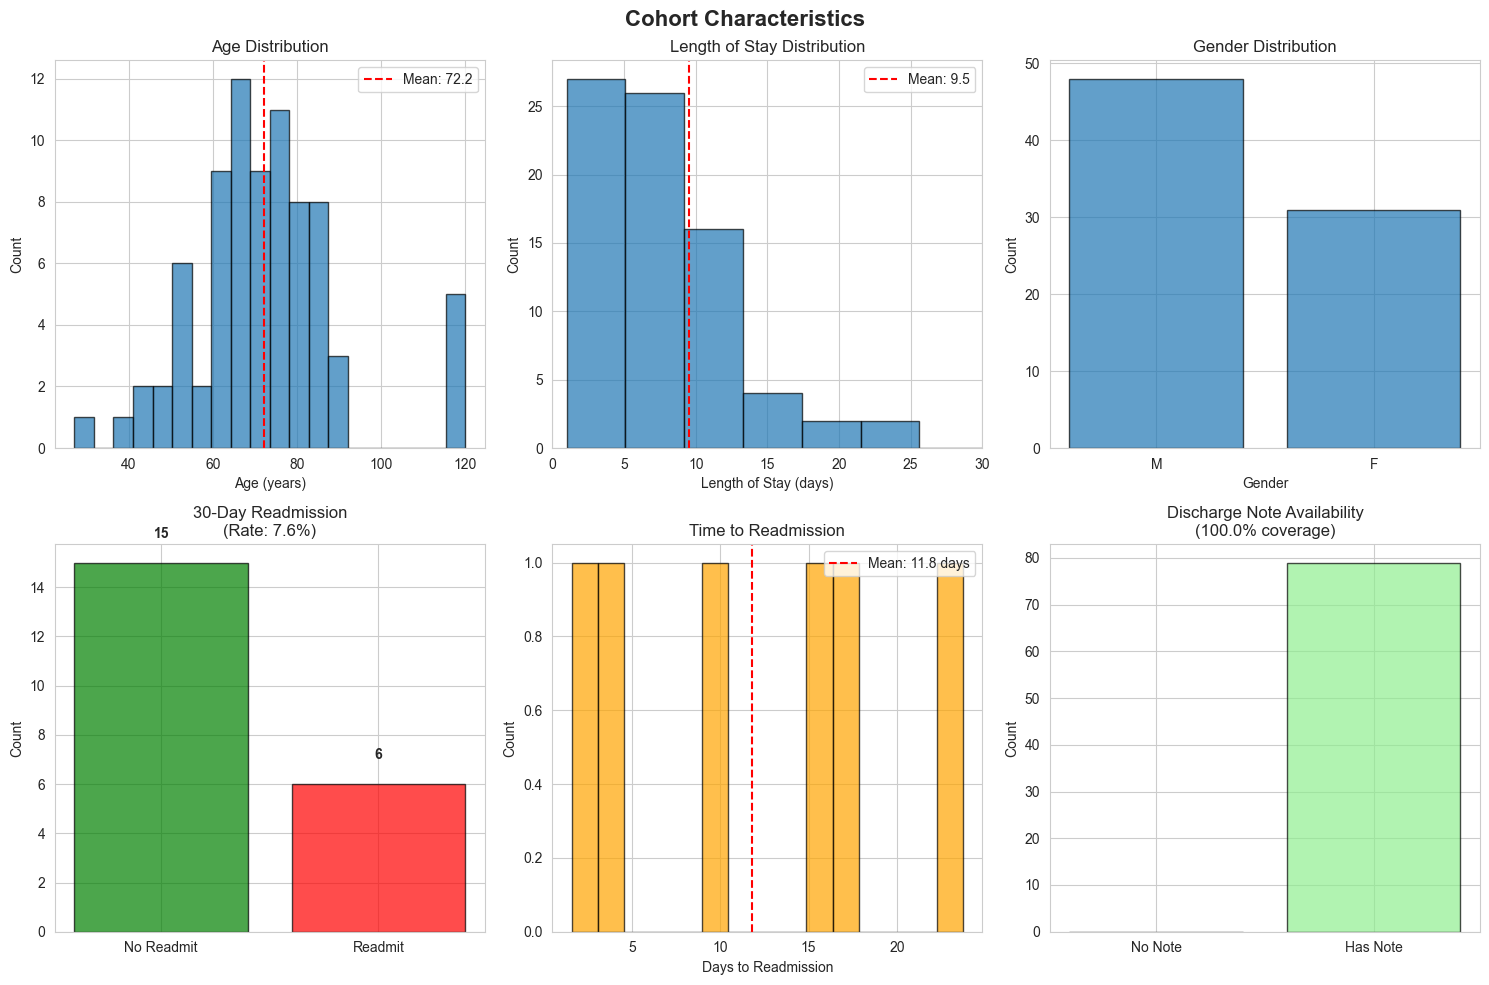

In [9]:
# Cell 9: Visualizations
"""
Create visualization of cohort characteristics
"""
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Cohort Characteristics', fontsize=16, fontweight='bold')

# 1. Age distribution
axes[0, 0].hist(cohort['AGE'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(cohort['AGE'].mean(), color='red', linestyle='--', label=f'Mean: {cohort["AGE"].mean():.1f}')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# 2. Length of Stay distribution
axes[0, 1].hist(cohort['LOS_DAYS'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(cohort['LOS_DAYS'].mean(), color='red', linestyle='--', label=f'Mean: {cohort["LOS_DAYS"].mean():.1f}')
axes[0, 1].set_xlabel('Length of Stay (days)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Length of Stay Distribution')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, min(30, cohort['LOS_DAYS'].max()))

# 3. Gender distribution
gender_counts = cohort['GENDER'].value_counts()
axes[0, 2].bar(gender_counts.index, gender_counts.values, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Gender Distribution')

# 4. Readmission outcome
readmit_counts = cohort[~cohort['IS_LAST_ADMISSION']]['READMIT_30'].value_counts()
axes[1, 0].bar(['No Readmit', 'Readmit'], 
               [readmit_counts.get(False, 0), readmit_counts.get(True, 0)],
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'30-Day Readmission\n(Rate: {readmission_rate*100:.1f}%)')
for i, v in enumerate([readmit_counts.get(False, 0), readmit_counts.get(True, 0)]):
    axes[1, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 5. Days to readmission (for readmitted patients)
readmitted = cohort[(cohort['READMIT_30'] == True) & (cohort['DAYS_TO_NEXT_ADMIT'].notna())]
if len(readmitted) > 0:
    axes[1, 1].hist(readmitted['DAYS_TO_NEXT_ADMIT'], bins=15, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Days to Readmission')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Time to Readmission')
    axes[1, 1].axvline(readmitted['DAYS_TO_NEXT_ADMIT'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {readmitted["DAYS_TO_NEXT_ADMIT"].mean():.1f} days')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No readmissions', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Time to Readmission')

# 6. Discharge note availability
note_avail = cohort['HAS_DISCHARGE_NOTE'].value_counts()
axes[1, 2].bar(['No Note', 'Has Note'], 
               [note_avail.get(False, 0), note_avail.get(True, 0)],
               color=['lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title(f'Discharge Note Availability\n({note_coverage*100:.1f}% coverage)')

plt.tight_layout()
plt.savefig('../outputs/figures/cohort_characteristics.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to outputs/figures/cohort_characteristics.png")
plt.show()



In [10]:
# Cell 10: Save Cohort Dataset
"""
Save the final cohort with readmission labels
"""
print("\n" + "="*60)
print("SAVING COHORT DATASET")
print("="*60)

# Select relevant columns for final cohort
cohort_columns = [
    'HADM_ID', 'SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
    'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
    'AGE', 'GENDER', 'LOS_DAYS',
    'READMIT_30', 'DAYS_TO_NEXT_ADMIT', 'IS_LAST_ADMISSION',
    'HAS_DISCHARGE_NOTE', 'DISCHARGE_TEXT'
]

final_cohort = cohort[cohort_columns].copy()

# Save to processed data folder
output_path = Path('../data/processed/cohort_with_outcomes.parquet')
output_path.parent.mkdir(parents=True, exist_ok=True)
final_cohort.to_parquet(output_path, index=False)

print(f"✓ Saved cohort to: {output_path}")
print(f"   Shape: {final_cohort.shape}")
print(f"   Size: {output_path.stat().st_size / 1024:.1f} KB")

# Also save as CSV for easy inspection
csv_path = output_path.with_suffix('.csv')
final_cohort.to_csv(csv_path, index=False)
print(f"✓ Also saved as CSV: {csv_path}")




SAVING COHORT DATASET
✓ Saved cohort to: ..\data\processed\cohort_with_outcomes.parquet
   Shape: (79, 20)
   Size: 71.3 KB
✓ Also saved as CSV: ..\data\processed\cohort_with_outcomes.csv


In [11]:
# Cell 11: Generate Cohort Summary Report
"""
Create detailed summary report
"""
summary_report = {
    "cohort_definition": {
        "inclusion_criteria": [
            f"Age >= {min_age} years",
            f"Length of stay >= {min_los_hours} hours",
            "Non-elective admission (emergency/urgent)",
            "Has discharge time"
        ],
        "exclusion_criteria": [
            "In-hospital mortality",
            "Missing discharge time"
        ]
    },
    "cohort_size": {
        "initial_admissions": int(initial_count),
        "after_inclusion": int(before_exclusion),
        "after_exclusion": int(len(final_cohort)),
        "evaluable_for_readmission": int((~final_cohort['IS_LAST_ADMISSION']).sum())
    },
    "demographics": {
        "mean_age": float(final_cohort['AGE'].mean()),
        "std_age": float(final_cohort['AGE'].std()),
        "age_range": [float(final_cohort['AGE'].min()), float(final_cohort['AGE'].max())],
        "gender_distribution": final_cohort['GENDER'].value_counts().to_dict(),
        "top_ethnicities": final_cohort['ETHNICITY'].value_counts().head(5).to_dict()
    },
    "admission_characteristics": {
        "mean_los_days": float(final_cohort['LOS_DAYS'].mean()),
        "median_los_days": float(final_cohort['LOS_DAYS'].median()),
        "std_los_days": float(final_cohort['LOS_DAYS'].std()),
        "admission_types": final_cohort['ADMISSION_TYPE'].value_counts().to_dict()
    },
    "outcomes": {
        "n_readmissions": int(n_readmissions),
        "readmission_rate": float(readmission_rate),
        "mean_days_to_readmit": float(readmitted['DAYS_TO_NEXT_ADMIT'].mean()) if len(readmitted) > 0 else None
    },
    "data_availability": {
        "n_with_discharge_notes": int(n_with_notes),
        "discharge_note_coverage": float(note_coverage)
    }
}

report_path = Path('../outputs/results/cohort_summary.json')
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\n✓ Summary report saved to: {report_path}")




✓ Summary report saved to: ..\outputs\results\cohort_summary.json


In [12]:
# Cell 12: Next Steps
print("\n" + "="*60)
print("COHORT DEFINITION COMPLETE!")
print("="*60)
print(f"\n✅ Final cohort: {len(final_cohort)} admissions")
print(f"✅ Readmission rate: {readmission_rate*100:.2f}%")
print(f"✅ Discharge note coverage: {note_coverage*100:.1f}%")
print(f"\n📊 Outputs saved:")
print(f"   - Cohort data: data/processed/cohort_with_outcomes.parquet")
print(f"   - Visualization: outputs/figures/cohort_characteristics.png")
print(f"   - Summary: outputs/results/cohort_summary.json")
print(f"\n📝 Next Steps:")
print("   1. Review cohort characteristics above")
print("   2. Proceed to notebook 03_feature_engineering.ipynb")
print("   3. Extract structured features for modeling")


COHORT DEFINITION COMPLETE!

✅ Final cohort: 79 admissions
✅ Readmission rate: 7.59%
✅ Discharge note coverage: 100.0%

📊 Outputs saved:
   - Cohort data: data/processed/cohort_with_outcomes.parquet
   - Visualization: outputs/figures/cohort_characteristics.png
   - Summary: outputs/results/cohort_summary.json

📝 Next Steps:
   1. Review cohort characteristics above
   2. Proceed to notebook 03_feature_engineering.ipynb
   3. Extract structured features for modeling
